## EOFs for SAM, PSA1, PSA2 indices comparison between iCESM and MERRA2


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.path as mpath
import datetime
import pandas as pd
from scipy.stats.stats import pearsonr
from scipy.stats import ttest_ind
from scipy import signal
from IPython.display import display
import xarray as xr
import dask as da
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
from dask.array.rechunk import rechunk
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
import statsmodels.api as sm
from cartopy.util import add_cyclic_point
import netCDF4
from scipy import stats
import matplotlib.pyplot as plt

#for era
from eofs.xarray import Eof
from eofs.examples import example_data_path
np.seterr(divide='ignore', invalid='ignore')

%matplotlib inline

## Use Tagged Data, and use 75 years of it!

In [3]:
############# to be set #############

##Save .pkl file path
# PICKLE_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_Indices_as_CSV_19Nov2018'
model     = 'iCESM'

exp = 'CTRL'

XCHUNK = 144 #Full size chunk seems to make things run quickest
YCHUNK = 96 #Full Y size chunk makes things run quickest
ZCHUNK = 30 #Full Z size chunk 
TCHUNK = 912  #Run-time seems consistent with changes to TCHUNK, but 12 looks like best and logical

##Load CTRL netcdf as Xarray
CTRL_DATA_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_CTRL_LGM_ERA_Xarrays_as_netcdf_31Oct2018'
CTRL_DATA = xr.open_dataset(CTRL_DATA_PATH+'/CTRL_DATA_TAGGED.nc')

##Save figure file path
FIG_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Figures_For_REVIEW_Submission_24March2021'


CTRL_DATA

<xarray.Dataset>
Dimensions:       (lat: 96, lon: 144, time: 912)
Coordinates:
  * time          (time) datetime64[ns] 1701-01-31 1701-02-28 ... 1776-12-31
  * lat           (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon           (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables: (12/61)
    land_frac     (time, lat, lon) float32 ...
    sst           (time, lat, lon) float32 ...
    msl           (time, lat, lon) float32 ...
    u10           (time, lat, lon) float32 ...
    v10           (time, lat, lon) float32 ...
    t2m           (time, lat, lon) float32 ...
    ...            ...
    tp_Ind_65     (time, lat, lon) float32 ...
    tp_Ind_75     (time, lat, lon) float32 ...
    d18O_AA_ice   (time, lat, lon) float32 ...
    d18O_AA_land  (time, lat, lon) float32 ...
    tp_AA_ice     (time, lat, lon) float32 ...
    tp_AA_land    (time, lat, lon) float32 ...

In [4]:
############# to be set #############

##Save figure file path
# PICKLE_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_Indices_as_CSV_19Nov2018'

##Save .nc file path
NETCDF_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_CTRL_LGM_ERA_Xarrays_as_netcdf_31Oct2018'

##Specific to MERRA2, ie, not the same chunk and slices as iCESM
XCHUNK = 240 #Full size chunk seems to make things run quickest
YCHUNK = 121 #Full Y size chunk makes things run quickest
#ZCHUNK = 30 #Full Z size chunk 
TCHUNK = 456  #Full T size (198001-201712) -- One year less that ERA-Interim


##Save figure file path
FIG_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Figures_For_REVIEW_Submission_24March2021'


In [5]:
#For ERA, decode_cf needs to be set to True for proper concatenation on T axis
merra_disk = xr.open_dataset(NETCDF_PATH+'/MERRA_DATA.nc')
print(merra_disk)
era_disk = xr.open_dataset(NETCDF_PATH+'/ERA_DATA.nc')
print(era_disk)

<xarray.Dataset>
Dimensions:  (lat: 121, lon: 240, time: 456)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2017-12-01
  * lat      (lat) float64 90.0 88.5 87.0 85.5 84.0 ... -85.5 -87.0 -88.5 -90.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
Data variables:
    skint    (time, lat, lon) float32 ...
    sst      (time, lat, lon) float32 ...
    msl      (time, lat, lon) float32 ...
    u10      (time, lat, lon) float32 ...
    v10      (time, lat, lon) float32 ...
    t2m      (time, lat, lon) float32 ...
    tp       (time, lat, lon) float32 ...
    ci       (time, lat, lon) float32 ...
<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 240, time: 468)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2017-12-01
  * latitude   (latitude) float32 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude  (longitude) float32 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
Data variables:
    sst

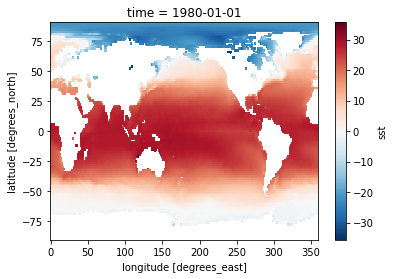

In [6]:
merra_disk.sst[0].plot()

In [7]:
#getting variables in right units 
slp_tmon_ctrl = CTRL_DATA.data_vars['msl']/100 #hPa
v10_tmon_ctrl = CTRL_DATA.data_vars['v10'] #in m/s at 10m
u10_tmon_ctrl = CTRL_DATA.data_vars['u10'] #in m/s at 10m
t2m_tmon_ctrl = CTRL_DATA.data_vars['t2m']-273.15 #in C
tp_tmon_ctrl  = CTRL_DATA.data_vars['tp']*60*60*24*1000  #in mm/day
ci_tmon_ctrl  = CTRL_DATA.data_vars['ci'] #in [0-1] fraction of sea ice
sst_tmon_ctrl  = CTRL_DATA.data_vars['sst']-273.15 #Equivalent to SST over ocean in C
d18O_tmon_ctrl = CTRL_DATA.data_vars['d18O'] #per mill
land_tmon_ctrl = CTRL_DATA.data_vars['land_frac']

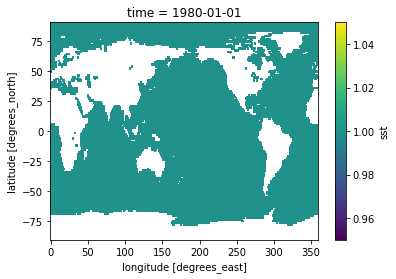

In [8]:
slp_tmon_merra = merra_disk.msl/100 #hPa
v10_tmon_merra = merra_disk.v10 #in m/s at 10m
u10_tmon_merra = merra_disk.u10 #in m/s at 10m
t2m_tmon_merra = merra_disk.t2m-273.15 #in C
tp_tmon_merra  = merra_disk.tp*60*60*24*1000/1000  #in mm/day
ci_tmon_merra  = merra_disk.ci #in [0-1] fraction of sea ice
sst_tmon_merra = merra_disk.sst #SST in C -- taken care of when making the xarray/.nc file
landsea_mask_merra = sst_tmon_merra[0]/sst_tmon_merra[0]
# landsea_mask_coords = xr.DataArray(landsea_mask, coords={'lat': MERRA1_DATA.coords['lat'],'lon': MERRA1_DATA.coords['lon']}, dims=('lat','lon'))
landsea_mask_merra.plot()

# iCESM1

## Calculate SAM and PSA1 and PSA2 indices via first 3 EOFs of Southern Hemi SLP Anoms  <br>
http://research.jisao.washington.edu/data/aao/slp/ -for SAM<br>
Also see Yu et al 2011 for definition of SAM (AAO) and PSA1 and PSA2
<br> <br>
The time series is calculated as follows:<br>
1a) Detrend the slp in the Southern Hemisphere region (South of 20S)<br>
1) SLP Anomalies are calculated for each calendar month with respect to the 00020101-00491231.  <br>
2) Each grid box is area weighted by the square root of the cosine of the central latitude.<br>
3) The covariance matrix of the area-weighted data is calculated for the grid boxes south of 20S, and the principal component (PC, timeseries ) calculated for that matrix. The first EOF is SAM, the second is PSA1 (Pacific-South American teleconnection, and third is PSA2 - see Yu et al 2011<br>
4) The mean and standard deviation are adjusted to be 0 and 1, respectively, for the period 00020101-00491231, all calendar months combined. This is a standard way to perform this calculation.<br>
**Not doing the rest:**<br>
4) The PC is correlated with global SLP anomalies, and that correlation map projected onto the data, including area weighting, to produce a time series for SAM for the entire record. (Not sure how he did this) <br>
5) The mean and standard deviation are adjusted to be 0 and 1, respectively, for the period 00020101-00491231, all calendar months combined. This is a standard way to perform this calculation.<br>

In [9]:
#params to be set
time_lo     = '1702-01-01'
time_hi    = '1776-12-31' 
# shem_xhi = 
# shem_xlo = 
shem_yhi = -20 #Had to reverse hi and lo lat values for ERA
shem_ylo = -90  #Had to reverse hi and lo lat values for ERA


In [10]:
slp_shem_tmon_ctrl = slp_tmon_ctrl.sel(time=slice(time_lo, time_hi), lat=slice(shem_ylo, shem_yhi))
#slp_shem_tmon_ctrl[0].plot()
slp_shem_tmon_ctrl

<xarray.DataArray 'msl' (time: 900, lat: 37, lon: 144)>
array([[[ 996.6037 ,  996.6037 ,  996.6037 , ...,  996.6037 ,
          996.6037 ,  996.6037 ],
        [ 997.1752 ,  997.19507,  997.23096, ...,  997.11346,
          997.13403,  997.1502 ],
        [ 997.50446,  997.5549 ,  997.6233 , ...,  997.1916 ,
          997.3371 ,  997.4171 ],
        ...,
        [1017.73486, 1017.0018 , 1016.0263 , ..., 1018.9361 ,
         1018.6802 , 1018.2876 ],
        [1016.7128 , 1015.9118 , 1014.9014 , ..., 1018.1376 ,
         1017.8054 , 1017.33276],
        [1015.64435, 1014.80786, 1013.81055, ..., 1017.16486,
         1016.79706, 1016.28516]],

       [[1002.2157 , 1002.2157 , 1002.21576, ..., 1002.21576,
         1002.2157 , 1002.2157 ],
        [1004.6919 , 1004.75336, 1004.80896, ..., 1004.46063,
         1004.55133, 1004.6245 ],
        [1006.86115, 1007.00336, 1007.1432 , ..., 1006.1856 ,
         1006.47107, 1006.68665],
...
        [1020.35986, 1019.58563, 1018.54584, ..., 1021.4786 ,
         1021.28827, 1020.9176 ],
        [1019.13635, 1018.2926 , 1017.1822 , ..., 1020.3736 ,
         1020.1552 , 1019.736  ],
        [1017.88104, 1017.00903, 1015.86884, ..., 1019.2291 ,
         1018.9383 , 1018.498  ]],

       [[ 996.7071 ,  996.7071 ,  996.7071 , ...,  996.7071 ,
          996.7071 ,  996.7071 ],
        [ 996.69257,  996.70807,  996.71844, ...,  996.66583,
          996.67554,  996.6824 ],
        [ 997.48444,  997.5265 ,  997.5968 , ...,  996.95087,
          997.15186,  997.341  ],
        ...,
        [1019.61755, 1018.7612 , 1017.64484, ..., 1021.0146 ,
         1020.72986, 1020.2439 ],
        [1018.2885 , 1017.40265, 1016.27655, ..., 1019.7664 ,
         1019.44305, 1018.9546 ],
        [1016.9863 , 1016.1101 , 1015.0334 , ..., 1018.4738 ,
         1018.12775, 1017.64233]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1702-01-31 1702-02-28 ... 1776-12-31
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... -25.58 -23.68 -21.79
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

In [11]:
#Step 1a)
#Detrend Southern Hem SLPs; use of scipy
#requires remapping back to xr dataArray 
#Returns the detrended slp data 
#the print lines help determine the shape and number of nans

aa1 = signal.detrend(slp_shem_tmon_ctrl, axis=0, type='linear', bp=0)
# print(4, aa1[0,25,11])
# print(5, aa1[0,25,33])
# print(6, np.count_nonzero(aa1[0,:,:]))


aa2 = xr.DataArray(aa1, coords={'time': slp_shem_tmon_ctrl.coords['time'], 'lat': slp_shem_tmon_ctrl.coords['lat'],'lon': slp_shem_tmon_ctrl.coords['lon']}, dims=('time','lat','lon'))
# print(7, aa2[0,25,11].values)
# print(8, aa2[0,25,33].values)
# print(9, np.count_nonzero(aa2[0,:,:]))

slp_shem_tmon_detrend_ctrl = aa2

# slp_shem_tmon_detrend_ctrl[0,:,:].plot() #2D map

In [12]:
#Create SLP Monthly Climatology from detrended data using data from time_lo to time_hi
slp_detrend_shem_climatology_ctrl = slp_shem_tmon_detrend_ctrl.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
# slp_detrend_shem_climatology_ctrl

#slp_detrend_shem_climatology_ctrl[:,90,24].plot()

In [13]:
#Step 1)
#Find Southern Hemisphere SLP Anoms using the climatology from time_lo to time_hi
slp_anoms_shem_tmon_detrend_ctrl = slp_shem_tmon_detrend_ctrl.groupby('time.month') - slp_detrend_shem_climatology_ctrl
#slp_anoms_shem_tmon_detrend_ctrl

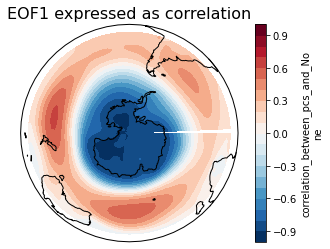

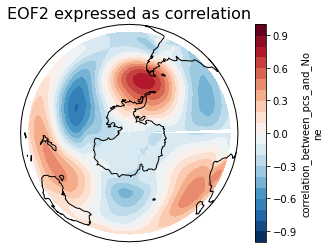

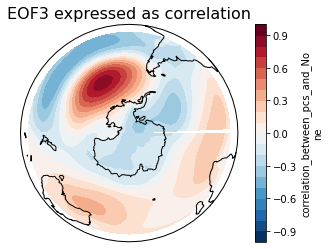

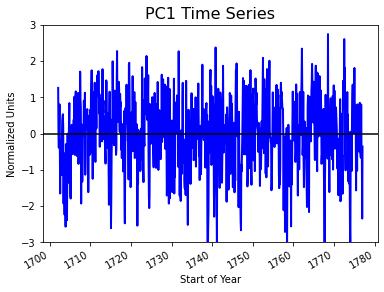

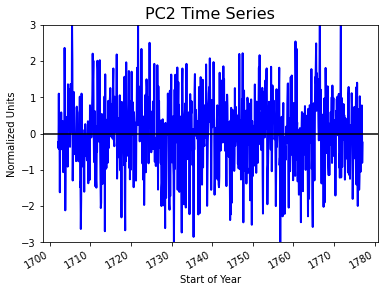

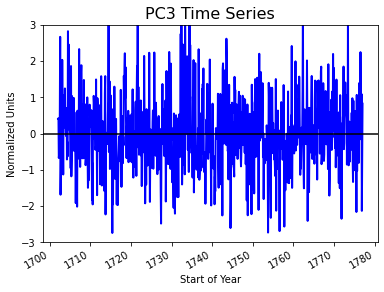

<xarray.DataArray 'variance_fractions' (mode: 3)>
array([0.29827803, 0.10393777, 0.08901694], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2
Attributes:
    long_name:  variance_fractions


In [14]:
"""
Compute and plot the 3 leading EOF of detrended SLP anomalies south of 20S

Includes Step 2), 3)

From Marshall and Thompson 2016, look at Fig 3, from this and my work with the PSA1, PSA2, SAM, 
correlations with T2M, PSA2 needs to have sign changes in order to get proper correlation with T2M.
"""

#Step 2)
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(slp_anoms_shem_tmon_detrend_ctrl.sel(lat=slice(shem_ylo, shem_yhi)).coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(slp_anoms_shem_tmon_detrend_ctrl.sel(lat=slice(shem_ylo, shem_yhi)), weights=wgts)

#Step 3)
# Retrieve the First Three EOF, expressed as the correlation between the leading
# PC time series and the input SLP anomalies at each grid point, and the
# leading PC time series itself.
eof1 = solver.eofsAsCorrelation(neofs=3)
pc1 = solver.pcs(npcs=3, pcscaling=1)


# Plot the leading EOF expressed as correlation with SLP S of 20S
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
eof1[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('EOF1 expressed as correlation', fontsize=16)


# Plot the 2nd EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
eof1[1].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('EOF2 expressed as correlation', fontsize=16)

# Plot the 3rd EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
eof1[2].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('EOF3 expressed as correlation', fontsize=16)


# Plot the leading PC time series.
plt.figure()
pc1[:, 0].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Start of Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC1 Time Series', fontsize=16)


# Plot the 2nd PC time series.
plt.figure()
pc1[:, 1].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Start of Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC2 Time Series', fontsize=16)

# Plot the 2nd PC time series.
plt.figure()
pc1[:, 2].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Start of Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC3 Time Series', fontsize=16)


plt.show()

variance_fractions = solver.varianceFraction(neigs=3)  #number of eigenvalues, ie, number of modes
print(variance_fractions)

#print(pc1[:, 0].values)

In [15]:
#Step 4, normalize to 0 mean and 1 STD (the eof method actually already did this, so not much change in the time series)
SAM_tmon_ctrl = pc1[:, 0]
norm_SAM_tmon_ctrl = (SAM_tmon_ctrl - SAM_tmon_ctrl.mean())/SAM_tmon_ctrl.std()
# print(norm_SAM_tmon_ctrl.mean(),norm_SAM_tmon_ctrl.std())

PSA1_tmon_ctrl = pc1[:, 1]
norm_PSA1_tmon_ctrl = (PSA1_tmon_ctrl - PSA1_tmon_ctrl.mean())/PSA1_tmon_ctrl.std()
# print(norm_PSA1_tmon_ctrl.mean(),norm_PSA1_tmon_ctrl.std())

PSA2_tmon_ctrl = pc1[:, 2]
norm_PSA2_tmon_ctrl = (PSA2_tmon_ctrl - PSA2_tmon_ctrl.mean())/PSA2_tmon_ctrl.std()
# print(norm_PSA2_tmon_ctrl.mean(),norm_PSA2_tmon_ctrl.std())


In [16]:
norm_SAM_tmon_ctrl

<xarray.DataArray 'pcs' (time: 900)>
array([ 1.26568757e+00,  3.32197656e-02, -3.85030257e-01,  2.34310086e-01,
        8.10689359e-01, -5.68352548e-01, -1.64999472e+00, -1.84006545e-01,
       -8.55544138e-01, -1.14470562e+00, -1.13461443e+00, -1.64893347e-01,
        3.57159488e-01,  4.63870380e-01,  5.37975559e-01,  1.72030828e-01,
       -1.92776002e+00, -7.79261135e-01, -1.30666077e+00, -2.23486843e+00,
       -5.41403599e-01, -1.71797871e+00, -2.56672414e+00, -2.87733132e-01,
       -8.65102825e-01, -1.11114457e+00, -2.38716285e+00, -1.07213573e+00,
        1.32358563e-03, -1.21835115e+00, -1.35219995e+00, -3.63137789e-01,
        2.68751196e-01,  8.46497502e-01, -7.56805299e-01, -5.67295587e-01,
       -1.71651448e+00, -1.78930336e+00, -3.41440008e-01, -3.55316322e-01,
        2.44815403e-01, -4.02297665e-01, -5.64425160e-01, -2.42615976e-01,
       -4.38744261e-01,  1.54138699e-01,  3.87636578e-01, -1.17859761e-01,
        1.02161011e+00, -5.82129475e-01,  4.80749933e-01,  7.41242816e-01,
        1.16891929e+00, -1.44791488e-01,  3.50664276e-01, -6.12638740e-01,
       -7.16886263e-02,  1.07295694e+00,  1.50112164e-01,  1.12667891e+00,
       -8.32500810e-01, -5.26290487e-01, -5.14762979e-01,  1.58300269e-01,
        4.66220966e-02,  1.71392680e+00,  9.46795989e-01,  7.29086546e-01,
       -1.92681834e+00,  2.59662874e-01, -1.27103064e+00, -1.32408121e+00,
       -1.29008098e+00, -1.39225210e-01,  5.40317386e-02,  9.19122278e-02,
        9.14721530e-01,  2.67691522e-01,  1.61189363e-01,  1.13234963e+00,
...
        7.33487159e-01,  6.61899440e-01,  3.70189571e-01,  1.32037633e-01,
       -3.80173027e-01, -9.63424617e-01, -1.39607876e-01, -6.70549127e-01,
       -1.69977117e+00, -5.27397961e-01, -5.02649349e-01, -1.31943658e-01,
        1.34419685e-01,  9.53013885e-01, -1.86359619e+00, -1.67266639e+00,
        2.32947228e-01,  5.50544761e-01, -6.76918801e-01, -5.85204400e-01,
       -1.65752364e+00,  5.13841634e-01,  1.46330373e+00,  7.44062372e-01,
        8.47918015e-01,  2.61271490e+00,  6.86629803e-01,  1.81780105e+00,
       -4.44761118e-01, -1.01109609e+00,  9.33650805e-01,  1.52349789e-01,
        1.03416482e+00,  2.07538374e-02,  1.14968836e+00, -1.72758946e-01,
        5.27359495e-01, -1.31423894e+00,  5.52782319e-02, -1.47074617e-01,
       -1.38124200e+00, -1.15759538e+00, -2.58263383e+00, -3.46251914e+00,
       -3.08508584e-01, -1.00475003e+00,  6.59474522e-02, -1.02693994e+00,
        3.20305029e-01,  9.62983595e-01,  1.35508821e+00,  1.71938393e-02,
        7.38789913e-01,  3.99057454e-01,  6.43700967e-01,  1.81502407e+00,
        2.92627121e-02,  8.02003412e-01,  1.06795950e-01,  2.52443808e-01,
       -1.56443894e+00,  3.51412402e-01,  1.66063962e-01, -1.02243550e+00,
        8.09120647e-01, -6.01763903e-03, -4.89786282e-01, -4.33664432e-01,
       -5.79176890e-02,  8.00553975e-01,  4.01339584e-01,  8.54070250e-01,
       -4.99772452e-01, -5.57908240e-01, -6.63116886e-01,  8.06274075e-01,
       -4.41311489e-01, -5.79891745e-01, -2.34088248e+00, -3.59192868e-01])
Coordinates:
  * time     (time) datetime64[ns] 1702-01-31 1702-02-28 ... 1776-12-31
    mode     int64 0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [17]:
#For copying to Excel: C:\Users\Paul\Desktop\Tabor\SAM_Trials_with_EOF_from_WASH_U_Definition.xlsx
series = norm_SAM_tmon_ctrl.to_series()

pd_series = pd.Series.to_frame(series)

# with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
#     print(pd_series)

In [18]:
#SAM, PSA1, PSA2 indices as pandas dataframe
#NOTE, negative center over AA (eof1), positive center ASL (eof2), negative center AP (eof3)
#NOTE, SAM IS OPPOSITE SIGN TO CORRECTED ERA-INTERIM, SO CHANGING SIGN HERE

df_SAM_ctrl = pd.DataFrame(norm_SAM_tmon_ctrl.values*(-1))
df_SAM_ctrl.columns = ['SAM']
#df_SAM_ctrl

df_PSA1_ctrl = pd.DataFrame(norm_PSA1_tmon_ctrl.values)
df_PSA1_ctrl.columns = ['PSA1']
#df_PSA1_ctrl

df_PSA2_ctrl = pd.DataFrame(norm_PSA2_tmon_ctrl.values)
df_PSA2_ctrl.columns = ['PSA2']
#df_SAM_ctrl

df_time_ctrl = pd.DataFrame(norm_SAM_tmon_ctrl.coords['time'].values)
df_time_ctrl.columns = ['time']
#df_time_ctrl

SAM_PSAs_indices_ctrl = pd.concat([df_time_ctrl, df_SAM_ctrl, df_PSA1_ctrl, df_PSA2_ctrl], axis=1)

# SAM_PSAs_indices_ctrl.to_pickle(PICKLE_PATH+'/ctrl_sam_psas_tmon.pkl')

SAM_PSAs_indices_ctrl.head(n=5)

,time,SAM,PSA1,PSA2
0,1702-01-31,-1.265688,-0.228069,0.415044
1,1702-02-28,-0.033220,-0.400461,0.427779
2,1702-03-31,0.385030,1.106482,-0.669459
3,1702-04-30,-0.234310,-0.424199,-0.555880
4,1702-05-31,-0.810689,0.222619,-0.564213


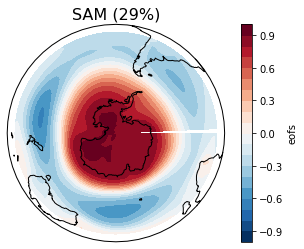

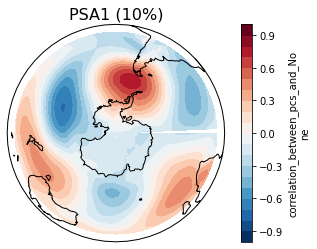

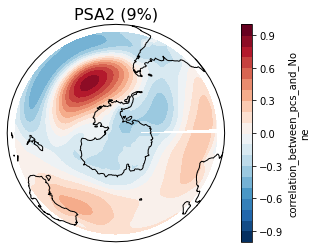

<xarray.DataArray 'variance_fractions' (mode: 3)>
array([0.29827803, 0.10393777, 0.08901694], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2
Attributes:
    long_name:  variance_fractions


In [19]:
# PLOTTING SAM and PSA1-2 EOFs with correct sign
"""
Compute and plot the 3 leading EOF of detrended SLP anomalies south of 20S

Includes Step 2), 3)
"""

#Step 2)
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(slp_anoms_shem_tmon_detrend_ctrl.sel(lat=slice(shem_ylo, shem_yhi)).coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(slp_anoms_shem_tmon_detrend_ctrl.sel(lat=slice(shem_ylo, shem_yhi)), weights=wgts)

#Step 3)
# Retrieve the First Three EOF, expressed as the correlation between the leading
# PC time series and the input SLP anomalies at each grid point, and the
# leading PC time series itself.
eof1 = solver.eofsAsCorrelation(neofs=3)
pc1 = solver.pcs(npcs=3, pcscaling=1)


# Plot the leading EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
eof1_sign = eof1[0]*(-1)
eof1_sign.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('SAM (29%)', fontsize=16)


# Plot the 2nd EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
eof1[1].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('PSA1 (10%)', fontsize=16)

# Plot the 3rd EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
eof1[2].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('PSA2 (9%)', fontsize=16)


# # Plot the leading PC time series.
# plt.figure()
# pc1[:, 0].plot(color='b', linewidth=2)
# ax = plt.gca()
# ax.axhline(0, color='k')
# ax.set_ylim(-3, 3)
# ax.set_xlabel('Start of Year')
# ax.set_ylabel('Normalized Units')
# ax.set_title('PC1 Time Series', fontsize=16)


# # Plot the 2nd PC time series.
# plt.figure()
# pc1[:, 1].plot(color='b', linewidth=2)
# ax = plt.gca()
# ax.axhline(0, color='k')
# ax.set_ylim(-3, 3)
# ax.set_xlabel('Start of Year')
# ax.set_ylabel('Normalized Units')
# ax.set_title('PC2 Time Series', fontsize=16)

# # Plot the 2nd PC time series.
# plt.figure()
# pc1[:, 2].plot(color='b', linewidth=2)
# ax = plt.gca()
# ax.axhline(0, color='k')
# ax.set_ylim(-3, 3)
# ax.set_xlabel('Start of Year')
# ax.set_ylabel('Normalized Units')
# ax.set_title('PC3 Time Series', fontsize=16)

#plt.savefig(FIG_PATH+'/fig02_ctrl_sam_and_psas_eof_maps.png',bbox_inches='tight', pad_inches=0.01)

plt.show()

variance_fractions = solver.varianceFraction(neigs=3)  #number of eigenvalues, ie, number of modes
print(variance_fractions)

#print(pc1[:, 0].values)

In [20]:
# PLOTTING SAM and PSA1-2 EOFs with correct sign
"""
Compute and plot the 3 leading EOF of detrended SLP anomalies south of 20S

Includes Step 2), 3)
"""

#Step 2)
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(slp_anoms_shem_tmon_detrend_ctrl.sel(lat=slice(shem_ylo, shem_yhi)).coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(slp_anoms_shem_tmon_detrend_ctrl.sel(lat=slice(shem_ylo, shem_yhi)), weights=wgts)

#Step 3)
# Retrieve the First Three EOF, expressed as the correlation between the leading
# PC time series and the input SLP anomalies at each grid point, and the
# leading PC time series itself.
eof1 = solver.eofsAsCorrelation(neofs=3)
pc1 = solver.pcs(npcs=3, pcscaling=1)


variance_fractions = solver.varianceFraction(neigs=3)  #number of eigenvalues, ie, number of modes
print(variance_fractions)




sam_eof_ctrl  = eof1[0]
sam_eof_ctrl  = sam_eof_ctrl.persist()
psa1_eof_ctrl = eof1[2]
psa1_eof_ctrl = psa1_eof_ctrl.persist()
psa2_eof_ctrl = eof1[1]*(-1)
psa2_eof_ctrl = psa2_eof_ctrl.persist()

<xarray.DataArray 'variance_fractions' (mode: 3)>
array([0.29827803, 0.10393777, 0.08901694], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2
Attributes:
    long_name:  variance_fractions


Text(0.5, 1.0, 'PSA2 (10%)')

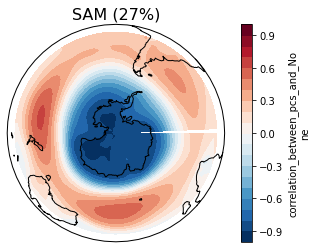

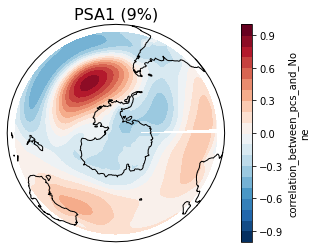

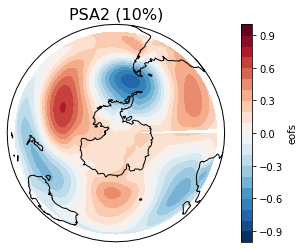

In [21]:
# Plot the leading EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
sam_eof_ctrl.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('SAM (27%)', fontsize=16)


# Plot the 2nd EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
psa1_eof_ctrl.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('PSA1 (9%)', fontsize=16)

# Plot the 3rd EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
psa2_eof_ctrl.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('PSA2 (10%)', fontsize=16)

# MERRA2

## Calculate SAM and PSA1 and PSA2 indices via first 3 EOFs of Southern Hemi SLP Anoms <br>
http://research.jisao.washington.edu/data/aao/slp/ -for SAM<br>
Also see Yu et al 2011 for definition of SAM (AAO) and PSA1 and PSA2
<br> <br>
The time series is calculated as follows:<br>
1a) Detrend the slp in the Southern Hemisphere region (South of 20S)<br>
1) SLP Anomalies are calculated for each calendar month with respect to the 00020101-00491231.  <br>
2) Each grid box is area weighted by the square root of the cosine of the central latitude.<br>
3) The covariance matrix of the area-weighted data is calculated for the grid boxes south of 20S, and the principal component (PC, timeseries ) calculated for that matrix. The first EOF is SAM, the second is PSA1 (Pacific-South American teleconnection, and third is PSA2 - see Yu et al 2011<br>
4) The mean and standard deviation are adjusted to be 0 and 1, respectively, for the period 00020101-00491231, all calendar months combined. This is a standard way to perform this calculation.<br>
**Not doing the rest:**<br>
4) The PC is correlated with global SLP anomalies, and that correlation map projected onto the data, including area weighting, to produce a time series for SAM for the entire record. (Not sure how he did this) <br>
5) The mean and standard deviation are adjusted to be 0 and 1, respectively, for the period 00020101-00491231, all calendar months combined. This is a standard way to perform this calculation.<br>

In [22]:
#params to be set

#Time period to calc seasonal (monthly) cycle:
time_lo     = '1980-01-01'
time_hi    = '2017-12-01'
# shem_xhi = 
# shem_xlo = 
# shem_yhi = -20 #Had to reverse hi and lo lat values for ERA
# shem_ylo = -90  #Had to reverse hi and lo lat values for ERA


In [23]:
#params to be set
shem_yhi = -90 #Had to reverse hi and lo lat values for ERA & MERRA
shem_ylo = -20  #Had to reverse hi and lo lat values for ERA & MERRA


In [24]:
slp_shem_tmon_merra = slp_tmon_merra.sel(time=slice(time_lo, time_hi), lat=slice(shem_ylo, shem_yhi))
slp_shem_tmon_merra

<xarray.DataArray 'msl' (time: 456, lat: 47, lon: 240)>
array([[[1017.3772 , 1017.0489 , 1016.6532 , ..., 1018.01544,
         1017.8471 , 1017.6412 ],
        [1018.1129 , 1017.80786, 1017.42596, ..., 1018.73096,
         1018.5636 , 1018.36115],
        [1018.806  , 1018.52783, 1018.1726 , ..., 1019.4014 ,
         1019.2422 , 1019.0449 ],
        ...,
        [ 999.406  ,  999.50073,  999.59515, ...,  999.12286,
          999.2166 ,  999.3113 ],
        [ 999.2244 ,  999.2603 ,  999.3063 , ...,  999.1555 ,
          999.17896,  999.20197],
        [ 998.4744 ,  998.4744 ,  998.4744 , ...,  998.4744 ,
          998.4744 ,  998.4744 ]],

       [[1015.63403, 1015.2942 , 1014.91705, ..., 1016.334  ,
         1016.1587 , 1015.92975],
        [1016.43445, 1016.09436, 1015.7118 , ..., 1017.09674,
         1016.9316 , 1016.71686],
        [1017.2199 , 1016.9088 , 1016.53394, ..., 1017.8485 ,
         1017.6785 , 1017.47815],
...
        [ 989.80835,  989.92487,  990.04175, ...,  989.4659 ,
          989.5774 ,  989.6925 ],
        [ 990.46075,  990.51373,  990.57227, ...,  990.3253 ,
          990.3702 ,  990.4153 ],
        [ 990.14484,  990.14484,  990.14484, ...,  990.14484,
          990.14484,  990.14484]],

       [[1017.66736, 1017.33344, 1016.9357 , ..., 1018.4512 ,
         1018.2311 , 1017.9671 ],
        [1018.45807, 1018.1064 , 1017.72144, ..., 1019.2265 ,
         1019.0249 , 1018.764  ],
        [1019.28284, 1018.9344 , 1018.54193, ..., 1019.9871 ,
         1019.8155 , 1019.58984],
        ...,
        [ 992.35333,  992.4121 ,  992.4729 , ...,  992.18994,
          992.2422 ,  992.2969 ],
        [ 993.40955,  993.44525,  993.48474, ...,  993.3186 ,
          993.34827,  993.3786 ],
        [ 993.5281 ,  993.5281 ,  993.5281 , ...,  993.5281 ,
          993.5281 ,  993.5281 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2017-12-01
  * lat      (lat) float64 -21.0 -22.5 -24.0 -25.5 ... -85.5 -87.0 -88.5 -90.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5

In [25]:
#Step 1a)
#Detrend Southern Hem SLPs; use of scipy
#requires remapping back to xr dataArray 
#Returns the detrended slp data 
#the print lines help determine the shape and number of nans

aa1 = signal.detrend(slp_shem_tmon_merra, axis=0, type='linear', bp=0)
# print(4, aa1[0,25,11])
# print(5, aa1[0,25,33])
# print(6, np.count_nonzero(aa1[0,:,:]))


aa2 = xr.DataArray(aa1, coords={'time': slp_shem_tmon_merra.coords['time'], 'lat': slp_shem_tmon_merra.coords['lat'],'lon': slp_shem_tmon_merra.coords['lon']}, dims=('time','lat','lon'))
# print(7, aa2[0,25,11].values)
# print(8, aa2[0,25,33].values)
# print(9, np.count_nonzero(aa2[0,:,:]))

slp_shem_tmon_detrend_merra = aa2

# slp_shem_tmon_detrend_merra[0,:,:].plot() #2D map

In [26]:
#Create SLP Monthly Climatology from detrended data using data from time_lo to time_hi
slp_detrend_shem_climatology_merra = slp_shem_tmon_detrend_merra.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
# slp_detrend_shem_climatology_merra

#slp_detrend_shem_climatology_merra[:,90,24].plot()

In [27]:
#Step 1)
#Find Southern Hemisphere SLP Anoms using the climatology from time_lo to time_hi
slp_anoms_shem_tmon_detrend_merra = slp_shem_tmon_detrend_merra.groupby('time.month') - slp_detrend_shem_climatology_merra
#slp_anoms_shem_tmon_detrend_merra

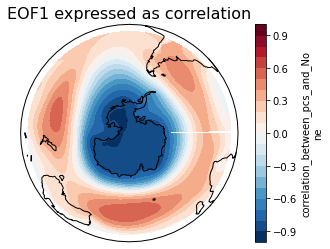

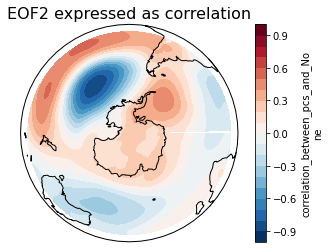

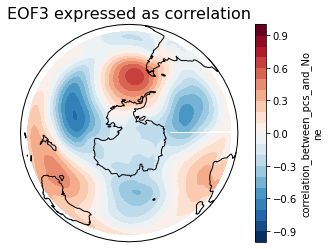

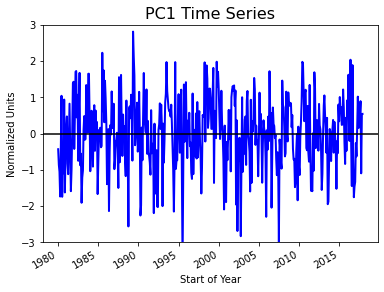

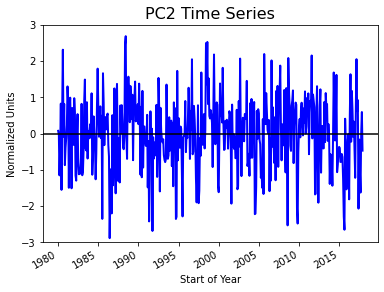

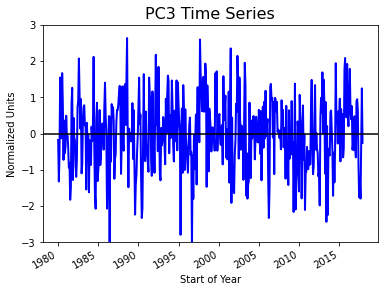

<xarray.DataArray 'variance_fractions' (mode: 3)>
array([0.2697225 , 0.11021259, 0.09389763], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2
Attributes:
    long_name:  variance_fractions


In [28]:
"""
Compute and plot the 3 leading EOF of detrended SLP anomalies south of 20S

Includes Step 2), 3)

From Marshall and Thompson 2016, look at Fig 3, from this and my work with the PSA1, PSA2, SAM, 
correlations with T2M, PSA2 needs to have sign changes in order to get proper correlation with T2M.
"""

#Step 2)
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(slp_anoms_shem_tmon_detrend_merra.sel(lat=slice(shem_ylo, shem_yhi)).coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(slp_anoms_shem_tmon_detrend_merra.sel(lat=slice(shem_ylo, shem_yhi)), weights=wgts)

#Step 3)
# Retrieve the First Three EOF, expressed as the correlation between the leading
# PC time series and the input SLP anomalies at each grid point, and the
# leading PC time series itself.
eof1 = solver.eofsAsCorrelation(neofs=3)
pc1 = solver.pcs(npcs=3, pcscaling=1)


# Plot the leading EOF expressed as correlation with SLP S of 20S
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
eof1[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('EOF1 expressed as correlation', fontsize=16)


# Plot the 2nd EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
eof1[1].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('EOF2 expressed as correlation', fontsize=16)

# Plot the 3rd EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
eof1[2].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('EOF3 expressed as correlation', fontsize=16)


# Plot the leading PC time series.
plt.figure()
pc1[:, 0].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Start of Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC1 Time Series', fontsize=16)


# Plot the 2nd PC time series.
plt.figure()
pc1[:, 1].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Start of Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC2 Time Series', fontsize=16)

# Plot the 2nd PC time series.
plt.figure()
pc1[:, 2].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Start of Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC3 Time Series', fontsize=16)


plt.show()

variance_fractions = solver.varianceFraction(neigs=3)  #number of eigenvalues, ie, number of modes
print(variance_fractions)

#print(pc1[:, 0].values)

In [29]:
#Step 4, normalize to 0 mean and 1 STD (the eof method actually already did this, so not much change in the time series)
SAM_tmon_merra = pc1[:, 0]
# print(SAM_tmon_merra.mean(),SAM_tmon_merra.std())
norm_SAM_tmon_merra = (SAM_tmon_merra - SAM_tmon_merra.mean())/SAM_tmon_merra.std()
# print(norm_SAM_tmon_merra.mean(),norm_SAM_tmon_merra.std())

PSA1_tmon_merra = pc1[:, 1]
norm_PSA1_tmon_merra = (PSA1_tmon_merra - PSA1_tmon_merra.mean())/PSA1_tmon_merra.std()
# print(norm_PSA1_tmon_merra.mean(),norm_PSA1_tmon_merra.std())

PSA2_tmon_merra = pc1[:, 2]
norm_PSA2_tmon_merra = (PSA2_tmon_merra - PSA2_tmon_merra.mean())/PSA2_tmon_merra.std()
# print(norm_PSA2_tmon_merra.mean(),norm_PSA2_tmon_merra.std())



In [30]:
#For copying to Excel: C:\Users\Paul\Desktop\Tabor\SAM_Trials_with_EOF_from_WASH_U_Definition.xlsx
series = norm_SAM_tmon_merra.to_series()

pd_series = pd.Series.to_frame(series)

# with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
#     print(pd_series)

In [31]:
#SAM, PSA1, PSA2 indices as pandas dataframe
#NOTE, negative center over AA (eof1), positive center ASL (eof2), negative center AP (eof3)
df_SAM_merra = pd.DataFrame(norm_SAM_tmon_merra.values)
df_SAM_merra.columns = ['SAM']
#df_SAM_merra

df_PSA1_merra = pd.DataFrame(norm_PSA1_tmon_merra.values)*(-1)
df_PSA1_merra.columns = ['PSA1']
#df_PSA1_merra

df_PSA2_merra = pd.DataFrame(norm_PSA2_tmon_merra.values)*(-1)
df_PSA2_merra.columns = ['PSA2']
#df_SAM_merra

df_time_merra = pd.DataFrame(norm_SAM_tmon_merra.coords['time'].values)
df_time_merra.columns = ['time']
#df_time_merra

SAM_PSAs_indices_merra = pd.concat([df_time_merra, df_SAM_merra, df_PSA1_merra, df_PSA2_merra], axis=1)

# SAM_PSAs_indices_merra.to_pickle(PICKLE_PATH+'/merra_sam_psas_tmon.pkl')

SAM_PSAs_indices_merra.head(n=5)
#SAM_PSAs_indices_merra.to_csv('Monthly_merra_SAM_PSAs.csv')

,time,SAM,PSA1,PSA2
0,1980-01-01,-0.429369,-0.078547,0.174077
1,1980-02-01,-0.866544,0.031309,1.320172
2,1980-03-01,-1.050691,1.151231,0.593894
3,1980-04-01,-1.737197,0.386887,-1.552102
4,1980-05-01,-0.420486,-0.829418,-0.691180


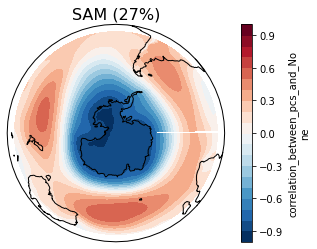

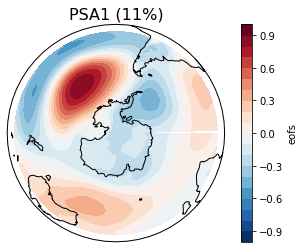

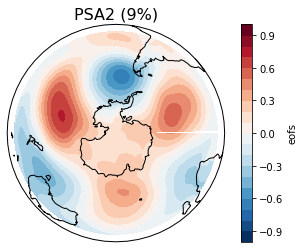

<xarray.DataArray 'variance_fractions' (mode: 3)>
array([0.2697225 , 0.11021259, 0.09389763], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2
Attributes:
    long_name:  variance_fractions


In [32]:
# PLOTTING SAM and PSA1-2 EOFs with correct sign (multiplying PSA2 by -1)
"""
Compute and plot the 3 leading EOF of detrended SLP anomalies south of 20S

Includes Step 2), 3)
"""

#Step 2)
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(slp_anoms_shem_tmon_detrend_merra.sel(lat=slice(shem_ylo, shem_yhi)).coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(slp_anoms_shem_tmon_detrend_merra.sel(lat=slice(shem_ylo, shem_yhi)), weights=wgts)

#Step 3)
# Retrieve the First Three EOF, expressed as the correlation between the leading
# PC time series and the input SLP anomalies at each grid point, and the
# leading PC time series itself.
eof1 = solver.eofsAsCorrelation(neofs=3)
pc1 = solver.pcs(npcs=3, pcscaling=1)


# Plot the leading EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
eof1[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('SAM (27%)', fontsize=16)


# Plot the 2nd EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
psa1_sign = eof1[1]*(-1)
psa1_sign.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('PSA1 (11%)', fontsize=16)

# Plot the 3rd EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
psa2_sign = eof1[2]*(-1)
psa2_sign.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('PSA2 (9%)', fontsize=16)


# # Plot the leading PC time series.
# plt.figure()
# pc1[:, 0].plot(color='b', linewidth=2)
# ax = plt.gca()
# ax.axhline(0, color='k')
# ax.set_ylim(-3, 3)
# ax.set_xlabel('Start of Year')
# ax.set_ylabel('Normalized Units')
# ax.set_title('PC1 Time Series', fontsize=16)


# # Plot the 2nd PC time series.
# plt.figure()
# pc1[:, 1].plot(color='b', linewidth=2)
# ax = plt.gca()
# ax.axhline(0, color='k')
# ax.set_ylim(-3, 3)
# ax.set_xlabel('Start of Year')
# ax.set_ylabel('Normalized Units')
# ax.set_title('PC2 Time Series', fontsize=16)

# # Plot the 2nd PC time series.
# plt.figure()
# pc1[:, 2].plot(color='b', linewidth=2)
# ax = plt.gca()
# ax.axhline(0, color='k')
# ax.set_ylim(-3, 3)
# ax.set_xlabel('Start of Year')
# ax.set_ylabel('Normalized Units')
# ax.set_title('PC3 Time Series', fontsize=16)

#plt.savefig(FIG_PATH+'/fig02_merra_sam_and_psas_eof_maps.png',bbox_inches='tight', pad_inches=0.01)

plt.show()

variance_fractions = solver.varianceFraction(neigs=3)  #number of eigenvalues, ie, number of modes
print(variance_fractions)

#print(pc1[:, 0].values)

## Setting the EOFs to the Appropriate SAM, PSA1, or PSA2 designation with the appropriate sign

In [34]:
# PLOTTING SAM and PSA1-2 EOFs with correct sign
"""
Compute and plot the 3 leading EOF of detrended SLP anomalies south of 20S

Includes Step 2), 3)
"""


#Step 2)
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(slp_anoms_shem_tmon_detrend_merra.sel(lat=slice(shem_ylo, shem_yhi)).coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(slp_anoms_shem_tmon_detrend_merra.sel(lat=slice(shem_ylo, shem_yhi)), weights=wgts)

#Step 3)
# Retrieve the First Three EOF, expressed as the correlation between the leading
# PC time series and the input SLP anomalies at each grid point, and the
# leading PC time series itself.
eof1 = solver.eofsAsCorrelation(neofs=3)
pc1 = solver.pcs(npcs=3, pcscaling=1)

variance_fractions = solver.varianceFraction(neigs=3)  #number of eigenvalues, ie, number of modes
print(variance_fractions)


sam_eof_merra  = eof1[0]
sam_eof_merra  = sam_eof_merra.persist()
psa1_eof_merra = eof1[1]*(-1)
psa1_eof_merra = psa1_eof_merra.persist()
psa2_eof_merra = eof1[2]*(-1)
psa2_eof_merra = psa2_eof_merra.persist()



<xarray.DataArray 'variance_fractions' (mode: 3)>
array([0.2697225 , 0.11021259, 0.09389763], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2
Attributes:
    long_name:  variance_fractions


Text(0.5, 1.0, 'PSA2 (9%)')

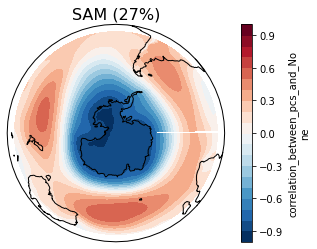

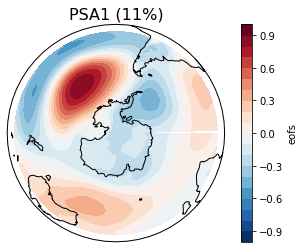

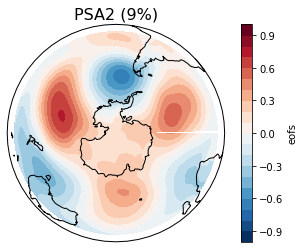

In [35]:
# Plot the leading EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
sam_eof_merra.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('SAM (27%)', fontsize=16)


# Plot the 2nd EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
psa1_eof_merra.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('PSA1 (11%)', fontsize=16)

# Plot the 3rd EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
psa2_eof_merra.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('PSA2 (9%)', fontsize=16)

# Plots

In [36]:
sam_eof_cyclic_ctrl, lons = add_cyclic_point(sam_eof_ctrl.values, sam_eof_ctrl.coords['lon'].values, axis=-1)
psa1_eof_cyclic_ctrl, lons = add_cyclic_point(psa1_eof_ctrl.values, psa1_eof_ctrl.coords['lon'].values, axis=-1)
psa2_eof_cyclic_ctrl, lons = add_cyclic_point(psa2_eof_ctrl.values, psa2_eof_ctrl.coords['lon'].values, axis=-1)
lon_orig_ctrl, lat_orig_ctrl = np.meshgrid(sam_eof_ctrl.coords['lon'].values, sam_eof_ctrl.coords['lat'].values)
lon_cyclic_ctrl, lat_cyclic_ctrl = np.meshgrid(lons, sam_eof_ctrl.coords['lat'].values)

In [37]:
sam_eof_cyclic_merra, lons = add_cyclic_point(sam_eof_merra.values, sam_eof_merra.coords['lon'].values, axis=-1)
psa1_eof_cyclic_merra, lons = add_cyclic_point(psa1_eof_merra.values, psa1_eof_merra.coords['lon'].values, axis=-1)
psa2_eof_cyclic_merra, lons = add_cyclic_point(psa2_eof_merra.values, psa2_eof_merra.coords['lon'].values, axis=-1)
lon_orig_merra, lat_orig_merra = np.meshgrid(sam_eof_merra.coords['lon'].values, sam_eof_merra.coords['lat'].values)
lon_cyclic_merra, lat_cyclic_merra = np.meshgrid(lons, sam_eof_merra.coords['lat'].values)

(37, 145)
(37, 145)
(37, 144)
(37, 145)
(37, 145)
(37, 144)
(37, 145)
(37, 145)
(37, 144)
(47, 241)
(47, 241)
(47, 240)
(47, 241)
(47, 241)
(47, 240)
(47, 241)
(47, 241)
(47, 240)


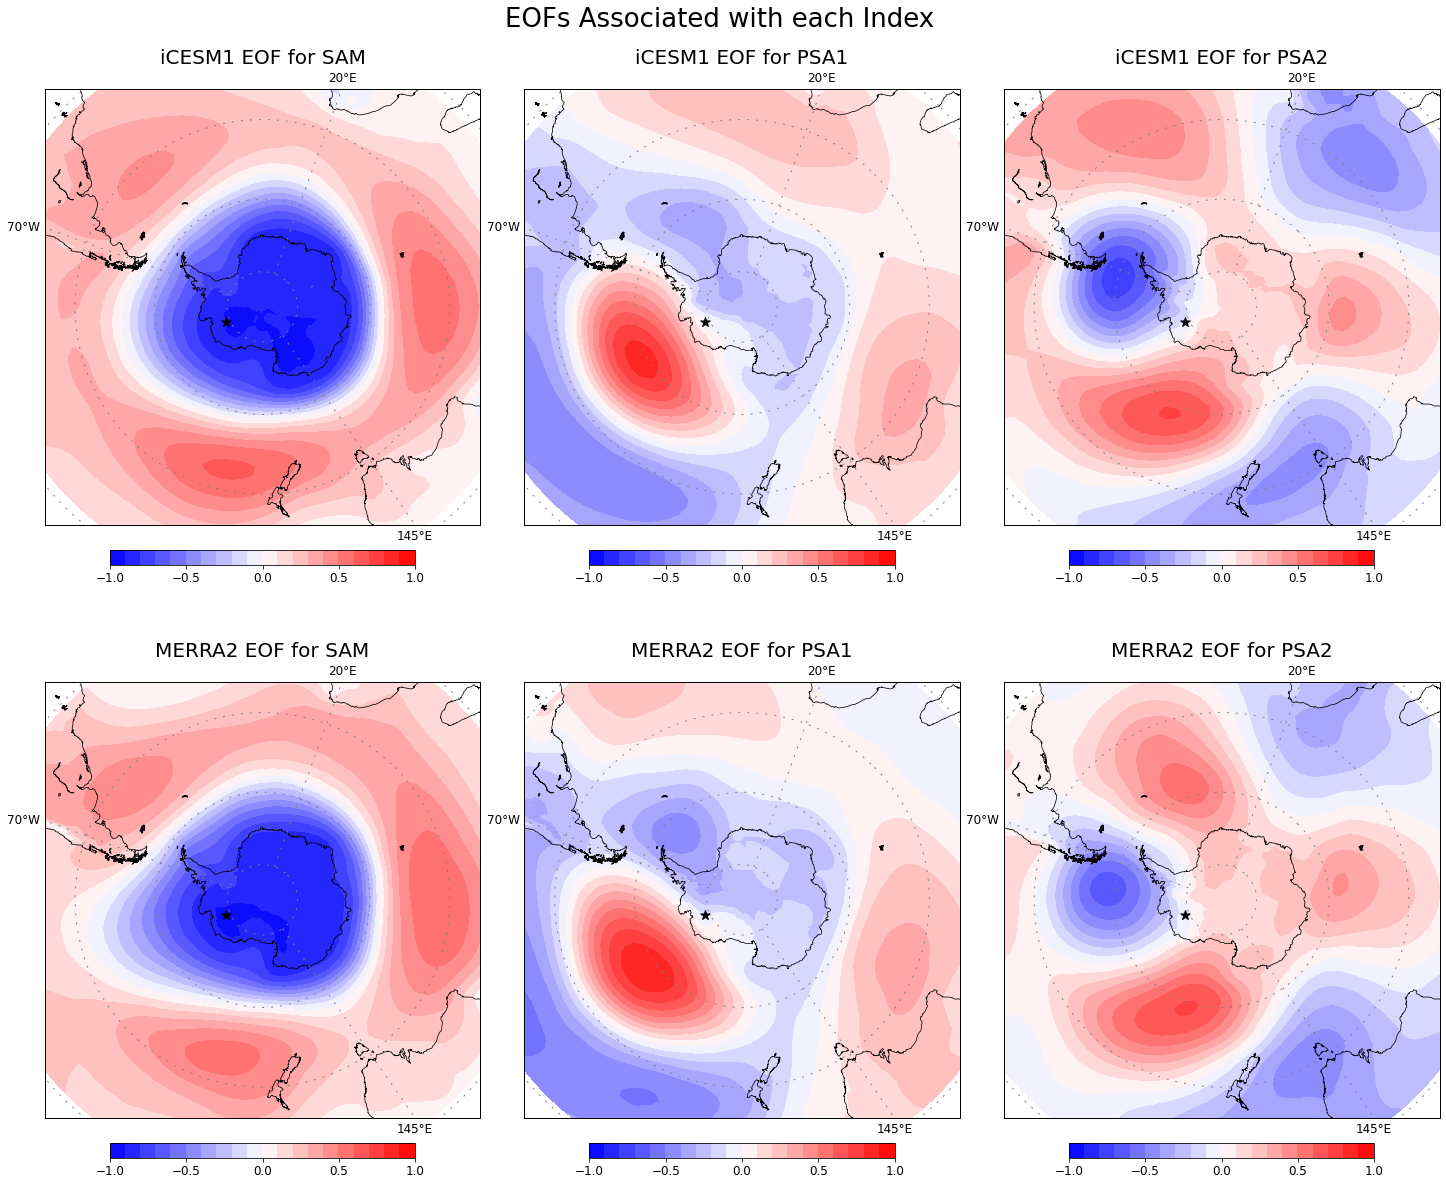

In [45]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,20), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('EOFs Associated with each Index', fontsize=26, y=.925)


parallels = np.arange(-80,-1,20)
# meridians = np.arange(0,360,30.)
meridians2 = [-70.,20.,145]
levels_shade = np.arange(-1,1.1,0.1)

plt.rcParams['contour.negative_linestyle'] = 'dashed'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

plt.subplot(2, 3, 1)
lon, lat = lon_cyclic_ctrl,lat_cyclic_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_ctrl.shape)
CS = m.contourf(x,y,sam_eof_cyclic_ctrl, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('iCESM1 EOF for SAM',y=1.045,fontsize=20)



plt.subplot(2, 3, 2)
lon, lat = lon_cyclic_ctrl,lat_cyclic_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_ctrl.shape)
CS = m.contourf(x,y,psa1_eof_cyclic_ctrl, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('iCESM1 EOF for PSA1',y=1.045,fontsize=20)




plt.subplot(2, 3, 3)
lon, lat = lon_cyclic_ctrl,lat_cyclic_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_ctrl.shape)
CS = m.contourf(x,y,psa2_eof_cyclic_ctrl, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('iCESM1 EOF for PSA2',y=1.045,fontsize=20)



plt.subplot(2, 3, 4)
lon, lat = lon_cyclic_merra,lat_cyclic_merra

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_merra.shape)
CS = m.contourf(x,y,sam_eof_cyclic_merra, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MERRA2 EOF for SAM',y=1.045,fontsize=20)



plt.subplot(2, 3, 5)
lon, lat = lon_cyclic_merra,lat_cyclic_merra

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_merra.shape)
CS = m.contourf(x,y,psa1_eof_cyclic_merra, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MERRA2 EOF for PSA1',y=1.045,fontsize=20)




plt.subplot(2, 3, 6)
lon, lat = lon_cyclic_merra,lat_cyclic_merra

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_merra.shape)
CS = m.contourf(x,y,psa2_eof_cyclic_merra, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MERRA2 EOF for PSA2',y=1.045,fontsize=20)





plt.savefig(FIG_PATH+'/Figure_iCESM_CTRL_vs_MERRA2_EOFs_13July2021.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

In [44]:
sam_eof_ctrl_value_at_WDC = sam_eof_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
print(sam_eof_ctrl_value_at_WDC.values)
sam_eof_merra_value_at_WDC = sam_eof_merra.sel(lat=-78.63, lon=247.5, method='nearest')
print(sam_eof_merra_value_at_WDC.values)

psa1_eof_ctrl_value_at_WDC = psa1_eof_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
print(psa1_eof_ctrl_value_at_WDC.values)
psa1_eof_merra_value_at_WDC = psa1_eof_merra.sel(lat=-78.63, lon=247.5, method='nearest')
print(psa1_eof_merra_value_at_WDC.values)

psa2_eof_ctrl_value_at_WDC = psa2_eof_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
print(psa2_eof_ctrl_value_at_WDC.values)
psa2_eof_merra_value_at_WDC = psa2_eof_merra.sel(lat=-78.63, lon=247.5, method='nearest')
print(psa2_eof_merra_value_at_WDC.values)

-0.8997251
-0.91497105
0.017253961
-0.07994726
-0.08238513
-0.062717505


(37, 145)
(37, 145)
(37, 144)
(37, 145)
(37, 145)
(37, 144)
(37, 145)
(37, 145)
(37, 144)


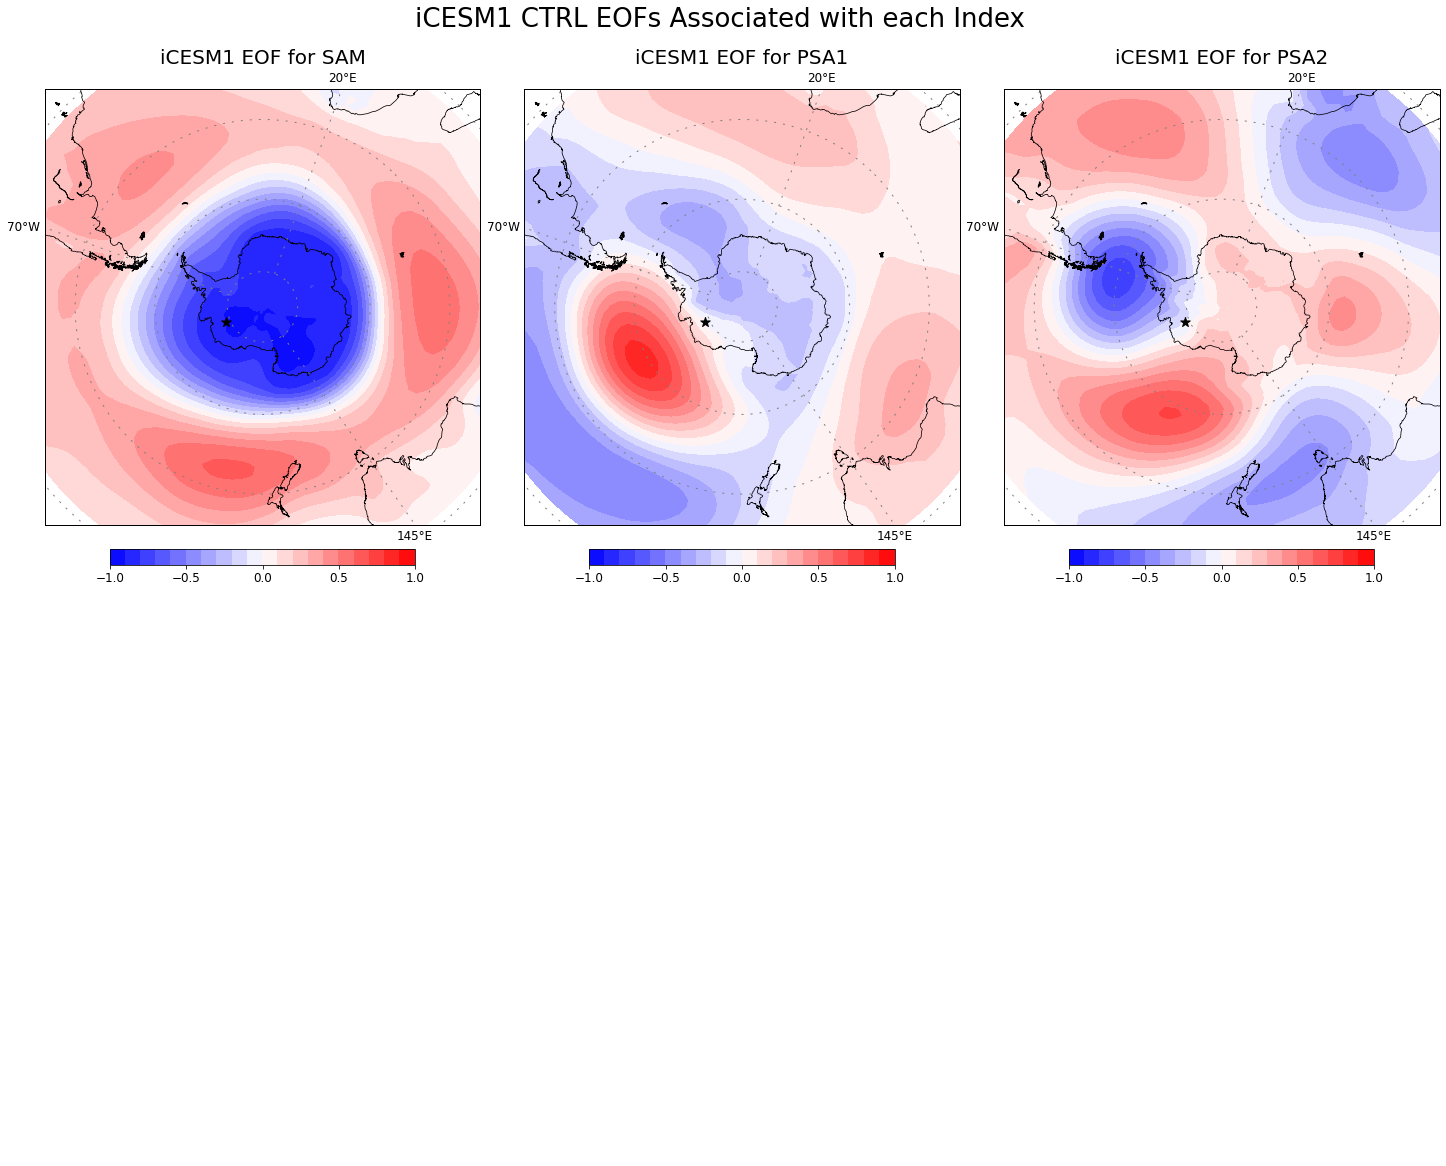

In [37]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,20), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('iCESM1 CTRL EOFs Associated with each Index', fontsize=26, y=.925)


parallels = np.arange(-80,-1,20)
# meridians = np.arange(0,360,30.)
meridians2 = [-70.,20.,145]
levels_shade = np.arange(-1,1.1,0.1)

plt.rcParams['contour.negative_linestyle'] = 'dashed'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

plt.subplot(2, 3, 1)
lon, lat = lon_cyclic_ctrl,lat_cyclic_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_ctrl.shape)
CS = m.contourf(x,y,sam_eof_cyclic_ctrl, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('iCESM1 EOF for SAM',y=1.045,fontsize=20)



plt.subplot(2, 3, 2)
lon, lat = lon_cyclic_ctrl,lat_cyclic_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_ctrl.shape)
CS = m.contourf(x,y,psa1_eof_cyclic_ctrl, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('iCESM1 EOF for PSA1',y=1.045,fontsize=20)




plt.subplot(2, 3, 3)
lon, lat = lon_cyclic_ctrl,lat_cyclic_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_ctrl.shape)
CS = m.contourf(x,y,psa2_eof_cyclic_ctrl, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('iCESM1 EOF for PSA2',y=1.045,fontsize=20)



ax[1, 0].axis('off')
ax[1, 1].axis('off')
ax[1, 2].axis('off')


# plt.savefig(FIG_PATH+'/Figure_iCESM_CTRL_TAGGED_IVT_wrt_JJA_PSA2_Quartiles_Pac_60to80S_07May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()